denoising-diffusion-pytorch python package

https://github.com/lucidrains/denoising-diffusion-pytorch

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

# CIFAR-10 parameters
image_size = 32
batch_size = 128

# Transformations for CIFAR-10
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(cifar10, batch_size=batch_size, shuffle=True, num_workers=4)

# Define UNet model
model = Unet(
    dim=64,
    dim_mults=(1, 2, 4),
    #channels=3,
    #self_condition=True
).to(device)

# Define diffusion process
diffusion = GaussianDiffusion(
    model,
    image_size=image_size,
    timesteps=1000,
    #loss_type='l1'
).to(device)

# Optimizer
optimizer = torch.optim.Adam(diffusion.parameters(), lr=2e-4)

epochs = 50
for epoch in range(epochs):
    for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        images = images.to(device)

        loss = diffusion(images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    if (epoch + 1) % 50 == 0:
        torch.save(diffusion.state_dict(), f'GaussianDiffusion_cfar10_checkpoint_epoch{epoch+1}.pth')

PATH = f'./GaussianDiffusion_cfar10_epochs{epochs}.pth'
torch.save(diffusion.state_dict(), PATH)




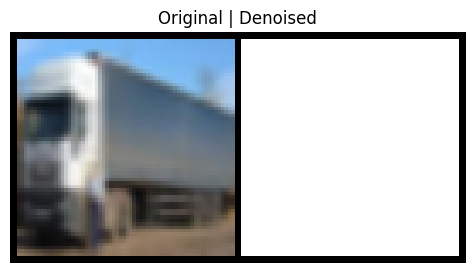

In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import random

# -----------------------------
# 1. Image Transforms
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# -----------------------------
# 2. Load CIFAR-10
# -----------------------------
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# -----------------------------
# 3. Define Model & Diffusion
# -----------------------------
model = Unet(
    dim=64,
    dim_mults=(1, 2, 4),
)

diffusion = GaussianDiffusion(
    model=model,
    image_size=64,
    timesteps=1000,
    objective='pred_noise'
)

# -----------------------------
# 4. Load Trained Checkpoint
# -----------------------------
checkpoint_path = "GaussianDiffusion_cfar10_checkpoint_epoch950.pth"
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)

# -----------------------------
# 5. Sampling with Conditioning
# -----------------------------
def sample_with_conditioning(diffusion, model, cond_img, timesteps=1000):
    model.eval()
    shape = cond_img.shape
    device = cond_img.device
    img = torch.randn(shape, device=device)

    for t in reversed(range(0, timesteps)):
        time = torch.full((1,), t, device=device, dtype=torch.long)
        x_self_cond = cond_img if getattr(model, 'self_condition', False) else None
        noise_pred = model(img, time, x_self_cond=x_self_cond)

        alpha = diffusion.alphas_cumprod[t]
        alpha_prev = diffusion.alphas_cumprod[t - 1] if t > 0 else torch.tensor(1.0, device=device)
        beta = 1 - alpha / alpha_prev
        mean = (1 / torch.sqrt(alpha)) * (img - beta * noise_pred / torch.sqrt(1 - alpha))

        if t > 0:
            noise = torch.randn_like(img)
            img = mean + torch.sqrt(beta) * noise
        else:
            img = mean

    return img

# -----------------------------
# 6. Generate Similar Image
# -----------------------------
def generate_similar_cifar10_image(model, device):
    model.eval()
    model.to(device)
    diffusion.model.to(device)

    rand_idx = random.randint(0, len(cifar10) - 1)
    image_tensor, label = cifar10[rand_idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        generated = sample_with_conditioning(diffusion, model, image_tensor)

    return image_tensor.squeeze(), generated.squeeze()

# -----------------------------
# 7. Display Side-by-Side Images
# -----------------------------
def show_images(original, generated):
    imgs = torch.stack([original, generated], dim=0)  # shape: [2, 3, 64, 64]
    imgs = (imgs.clamp(-1, 1) + 1) / 2  # unnormalize to [0, 1]
    grid = make_grid(imgs, nrow=2)
    plt.figure(figsize=(9, 3))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title("Original | Denoised")
    plt.axis("off")
    plt.show()

# -----------------------------
# 8. Main
# -----------------------------
if __name__ == "__main__":
    input_img, output_img = generate_similar_cifar10_image(model, device)
    show_images(input_img, output_img)